In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")
from scipy import stats
import warnings 
warnings.filterwarnings('ignore')

from pathlib import Path
csv_path = Path("data") / "train_merged.csv"
# csv_path = os.path.join("data", "train_merged.csv")   os ile alternatif..
import sys
import os
sys.path.append(str(Path.cwd() / 'functions'))
from utils import *

In [2]:
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'

In [3]:
df = pd.read_csv(csv_path, low_memory=False)
print(df.shape)
# display(df.head())

(590540, 434)


In [4]:
train_df = reduce_mem_usage(df.copy())

categorical_features = [
    'ProductCD', 'P_emaildomain', 'R_emaildomain','DeviceType', 'DeviceInfo',
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
    'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20',
    'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
    'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38'
]
numerical_features = [col for col in train_df.columns if col not in categorical_features]

resumetable(train_df[categorical_features])[:15]

Memory usage decreased to 645.97 Mb (67.0% reduction)
Dataset Shape: (590540, 49)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,ProductCD,object,0,5,W,W,W,1.28
1,P_emaildomain,object,94456,59,NaN,gmail.com,outlook.com,2.68
2,R_emaildomain,object,453249,60,NaN,NaN,NaN,2.76
3,DeviceType,object,449730,2,NaN,NaN,NaN,0.97
4,DeviceInfo,object,471874,1786,NaN,NaN,NaN,4.37
5,card1,int16,0,13553,13926,2755,4663,9.97
6,card2,float16,8933,500,NaN,404.0,490.0,6.32
7,card3,float16,1565,114,150.0,150.0,150.0,0.68
8,card4,object,1577,4,discover,mastercard,visa,1.09
9,card5,float16,4259,119,142.0,102.0,166.0,2.66


Entropy : 
    --> Measures the uncertainty or randomness of the data distribution in each column, using Shannon entropy. It quantifies how evenly the values are spread.

> **High entropy** (closer to log2 of unique values): Values are diverse and evenly distributed (e.g., many unique categories with similar frequencies).

> **Low entropy** (closer to 0): Values are concentrated (e.g., mostly one value or few dominant ones).

In [5]:
top_missing_cols(train_df, thresh=90)

There are 414 columns with missing values.
There are 12 columns with missing percent > 90%


,col,missing_percent
0,id_24,99.196159
1,id_25,99.130965
2,id_07,99.127070
3,id_08,99.127070
4,id_21,99.126393
5,id_26,99.125715
6,id_27,99.124699
7,id_23,99.124699
8,id_22,99.124699
9,dist2,93.628374


In [6]:
threshold = 95
high_missing = top_missing_cols(train_df, thresh=90)
cols_to_drop = high_missing[high_missing['missing_percent'] > threshold]['col'].tolist()

train_df = train_df.drop(columns=cols_to_drop)
print(f" {threshold}% üstü eksik olan {len(cols_to_drop)} sütun silindi")

There are 414 columns with missing values.
There are 12 columns with missing percent > 90%
 95% üstü eksik olan 9 sütun silindi


Bazı değişkenlerin %99 dan fazlasının eksik olduğu görülüyor. Bu değişkenlerden gelen bilgilerin modelin genelleme yeteneğini kötü etkileyeceğini düşünüyoruz.

Çok fazla eksik değere sahip olan özellikleri siliyoruz. Threshold belirlerken hedefteki oranın fazla değişmemesine dikkat ediyoruz.

### Target Analysis

Class distribution for 'isFraud':
isFraud
0    569877
1     20663
Name: count, dtype: int64

Percentage:
isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64


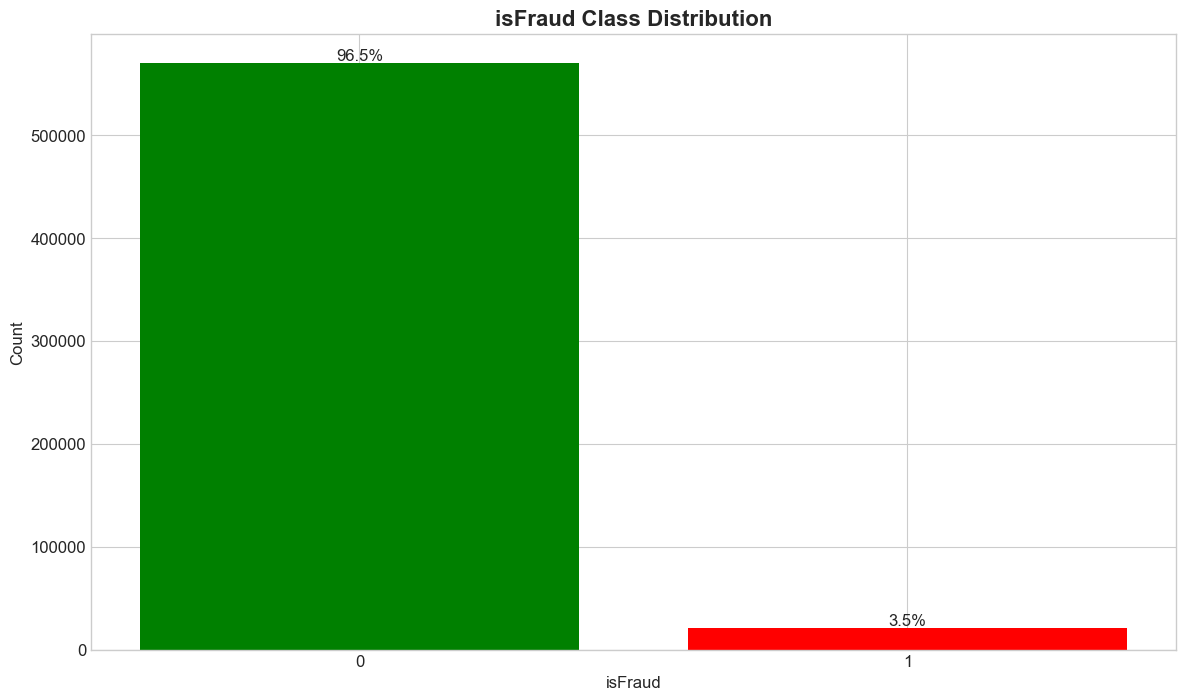

In [7]:
print("Class distribution for 'isFraud':")
print(train_df['isFraud'].value_counts())
print("\nPercentage:")
print(train_df['isFraud'].value_counts(normalize=True))

counts = train_df['isFraud'].value_counts()
percentages = train_df['isFraud'].value_counts(normalize=True) * 100

colors = ['green', 'red'] 
bars = plt.bar(counts.index, counts.values, color=colors[:len(counts)])

plt.title('isFraud Class Distribution')
plt.xlabel('isFraud')
plt.ylabel('Count')
plt.xticks([0, 1])

for bar, perc in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, f'{perc:.1f}%', ha='center', va='bottom')

plt.show()

# Categorical Features Analysis

Hedef değişkenin dengesiz olduğu görülmektedir. Bu nedenle modelleme aşamasında undersampling, oversampling veya sınıf ağırlıklarının ayarlanması gibi stratejiler değerlendirilebilir.

Kategorik özelliklerin tamamı analize uygun değildir. Bazı değişkenler yüksek kardinalite içerdiğinden doğrudan kategorik inceleme anlamlı sonuç vermemektedir. Bu nedenle kardinalitesi makul seviyede olan değişkenler ayrıştırılarak hedef değişkenle ilişkileri incelenmiştir.

Amaç, belirli kategorilerin bulunması veya belirli değerlerin gözlenmesi durumunda isFraud oranında kayda değer bir değişiklik olup olmadığını belirlemektir. Böyle bir ilişki tespit edilirse veri ön işleme aşamasında uygun dönüşümler yapılabilir.

Kategorik Özellikler

Transaction verileri:

ProductCD: İşlem ürün kodu.

card1–card6: Kart tipi, kart ülkesi vb. kart bilgileri.

addr1, addr2: Coğrafi adres bilgisi.

P_emaildomain: Alıcı/purchaser e-posta alan adı.

R_emaildomain: Gönderici/recipient e-posta alan adı.

M1–M9: Eşleşme durumları (kart sahibi–adres uyumu vb.)

Identity verileri:

DeviceType: İşlemde kullanılan cihaz türü.

DeviceInfo: Cihaz bilgisi (model, üretici vb.)

id_12–id_38: Ağ bağlantısı, tarayıcı bilgileri ve çeşitli oturum nitelikleri.

In [8]:
present_cols = [col for col in categorical_features if col in train_df.columns]
 
low_cardinality = [col for col in present_cols if train_df[col].nunique() <= 10]
high_cardinality = [col for col in present_cols if train_df[col].nunique() > 10]

categorical_features = low_cardinality
cardinality_features = high_cardinality # excluded

Çok fazla kategorik özellik var hala. Yapılan diğer çalışmalardan da faydalanarak en çok önemli görülenlerin incelenmesine daha fazla ağırlık verebiliriz.

Bu özellikleri konu başlıklarına göre ayırabiliriz.



In [9]:
card_features = [col for col in train_df.columns if col.startswith('card')]
# resumetable(train_df[card_features])

In [10]:
# for card3 , <200 -->others
valid_card3 = train_df['card3'].value_counts()
train_df.loc[train_df['card3'].isin(valid_card3[valid_card3 < 200].index), 'card3'] = "Others"

# for card5 , <300 --> others 
valid_card5 = train_df['card5'].value_counts()
train_df.loc[train_df['card5'].isin(valid_card5[valid_card5 < 300].index), 'card5'] = "Others"

train_df = (train_df
    .pipe(clean_email_domains)
    .pipe(analyze_email_match)
    .pipe(consolidate_device_info))

# Yöntem

## Test
Chi-Square testi + difference size (max fraud rate - min fraud rate)

p-değeri ve difference bizim için anlamlı ise o özelliğin tutulması , yeni eklenecek bir özellik ise eklenmesi anlamlı olacaktır.

Alternatif olarak her özelliği ayırıp her biri için Logistic Regression modeli kurmak ve sonucu değerlendirmek olabilir. Ayrıca En güenli ve en riskli alt sınıfların oran farkı yerine Entropy hesaplanabilirdi..

Dolandırıcılık gibi durumlarda safsızlık yerine en riskli olanı dikkate almak daha doğru gözüküyor.


Sonuçları Görsel olarak da sunmak gereklidir.

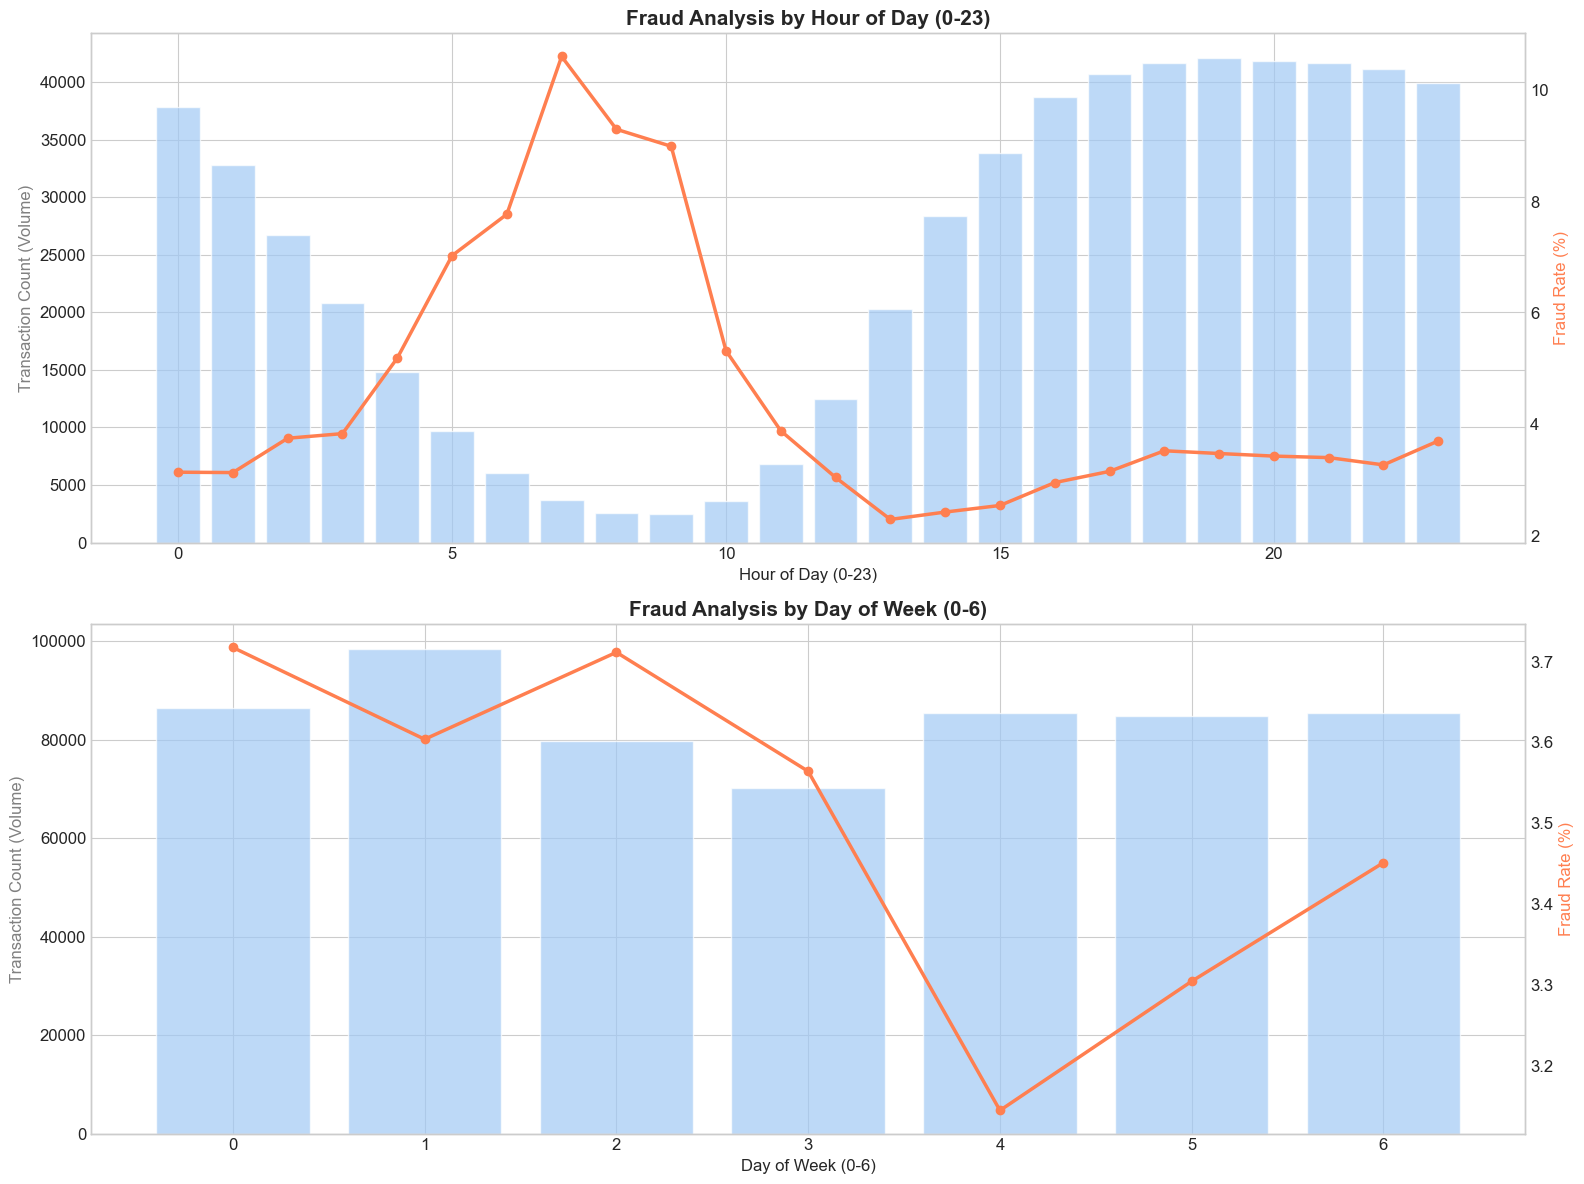

In [11]:
train_df = analyze_time_categories(train_df)

cat_binary_test ile şu soruya cevap aranıyor :
Elimizdeki kategorik özelliklerin farklı alt sınıfları , isFruad Değişkeninde anlamlı farklar oluşturuyor mu ?

Düşük-orta kardinaliteli kategorik feature’ların fraud ile ilişkisini hem istatistiksel hem de pratik açıdan test eder.

Basit bir mantığı var ancak anlalı sonuç veriyor.

In [12]:
cat_binary_test(train_df , ['DeviceType','ProductCD','card4','card6',
                            'M1','M2','M3','M4','M5','M6','id_35'])

,Feature,P_Value,Fraud_Rate_Min,Fraud_Rate_Max,Rate_Diff,Overall_Fraud_Rate,N_Categories,Min_Category_Size,Decision,Keep,Warning
0,ProductCD,0.0,0.0204,0.1169,0.0965,0.035,5,11628,Strong Relation,True,
1,M4,0.0,0.0271,0.1137,0.0867,0.035,3,52826,Strong Relation,True,
2,id_35,0.0,0.0447,0.1226,0.0779,0.035,2,63171,Strong Relation,True,
3,card6,0.0,0.0000,0.0668,0.0668,0.035,4,15,Strong Relation,True,Low sample size (15)
4,card4,0.0,0.0287,0.0773,0.0486,0.035,4,6651,Strong Relation,True,
5,DeviceType,0.0,0.0652,0.1017,0.0364,0.035,2,55645,Strong Relation,True,
6,M1,1.0,0.0000,0.0199,0.0199,0.035,2,25,Not Related,False,Low sample size (25)
7,M2,0.0,0.0181,0.0349,0.0168,0.035,2,33972,Enough Relation,True,
8,M3,0.0,0.0171,0.0303,0.0132,0.035,2,67709,Enough Relation,True,
9,M5,0.0,0.0265,0.0377,0.0112,0.035,2,107567,Enough Relation,True,



card1 ve card2 özellikleri için dağılım incelenmesi gerekiyor ! sorun çözüldükten sonra eklenmeli !

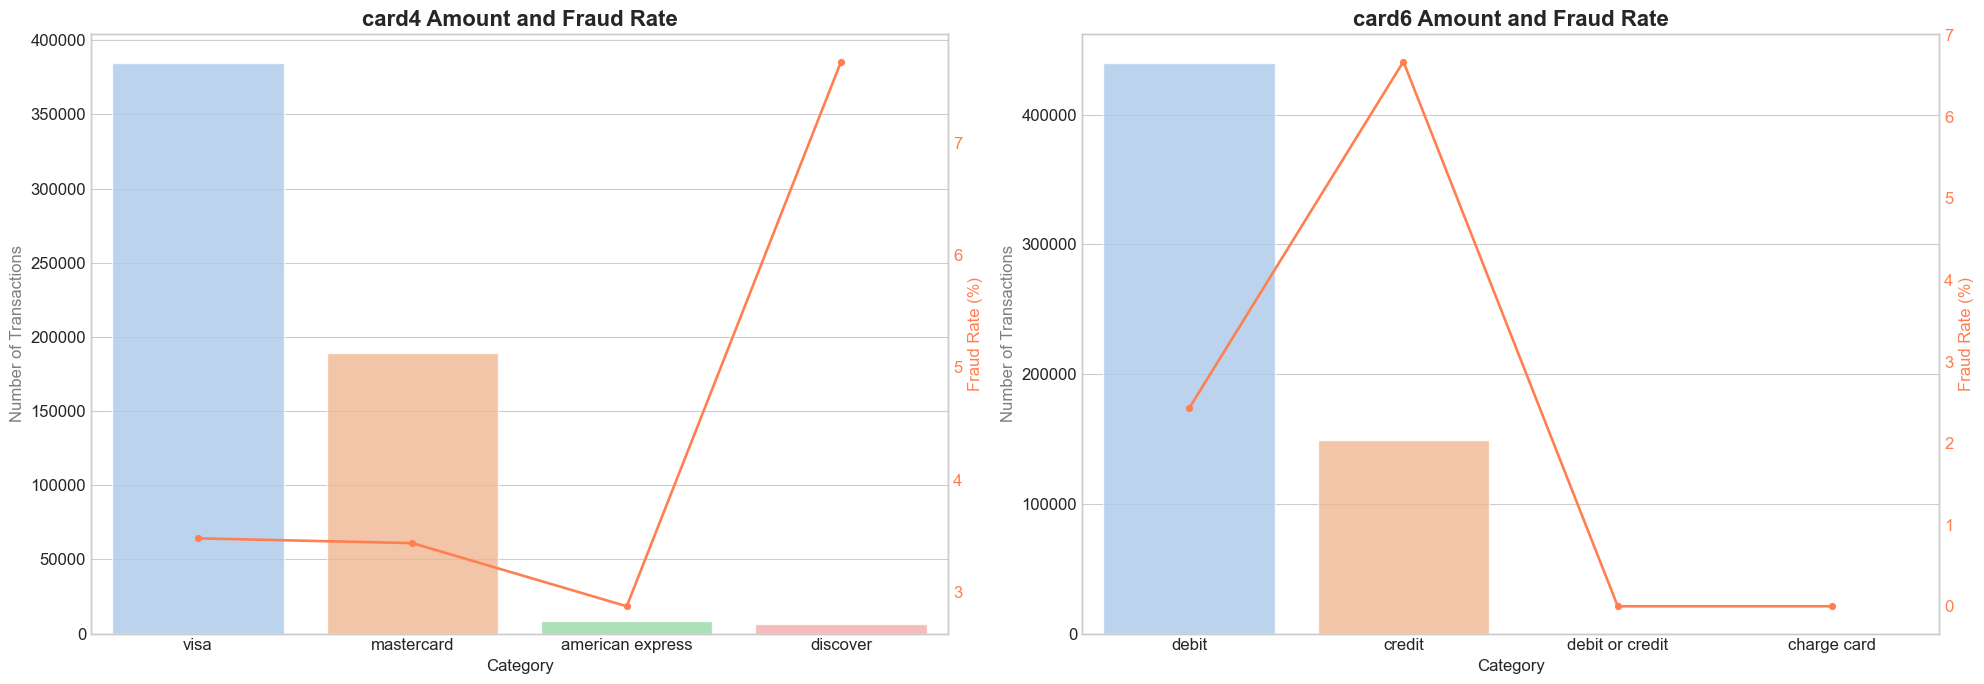

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

for i, col in enumerate(['card4', 'card6']):
    tmp = pd.crosstab(train_df[col], train_df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={1: 'FraudRate', 0: 'NoFraudRate'}, inplace=True)
    
    # Toplam işlem sayılarını da alalım
    total_count = train_df[col].value_counts().reset_index()
    total_count.columns = [col, 'Count']
    
    # Verileri birleştir (Merge)
    plot_data = pd.merge(total_count, tmp, on=col)
    plot_data = plot_data.sort_values(by='Count', ascending=False) # sort
    
    # --- 2. Çift Eksenli Grafik Çizimi ---
    ax1 = axes[i]
    ax2 = ax1.twinx() 
    
    # Bar Plot --> işlem hacmi
    sns.barplot(
        x=col, 
        y='Count', 
        data=plot_data, 
        ax=ax1, 
        palette='pastel', 
        alpha=0.8,
        edgecolor='white'
    )
    
    # Line Plot --> fraud yüzdesi
    sns.pointplot(
        x=col, 
        y='FraudRate', 
        data=plot_data, 
        ax=ax2, 
        color ='#ff7f50', 
        markers='o',
        scale=0.7 
    )
    
    
    ax1.set_title(f'{col} Amount and Fraud Rate', fontsize=16, fontweight='bold')
    
    
    ax1.set_xlabel('Category', fontsize=12)
    ax1.set_ylabel('Number of Transactions', fontsize=12, color='gray')
    ax2.set_ylabel('Fraud Rate (%)', fontsize=12, color='#ff7f50')
    
    
    ax2.tick_params(axis='y', colors='#ff7f50')
    
    
    ax2.grid(False)

plt.tight_layout()
plt.show()

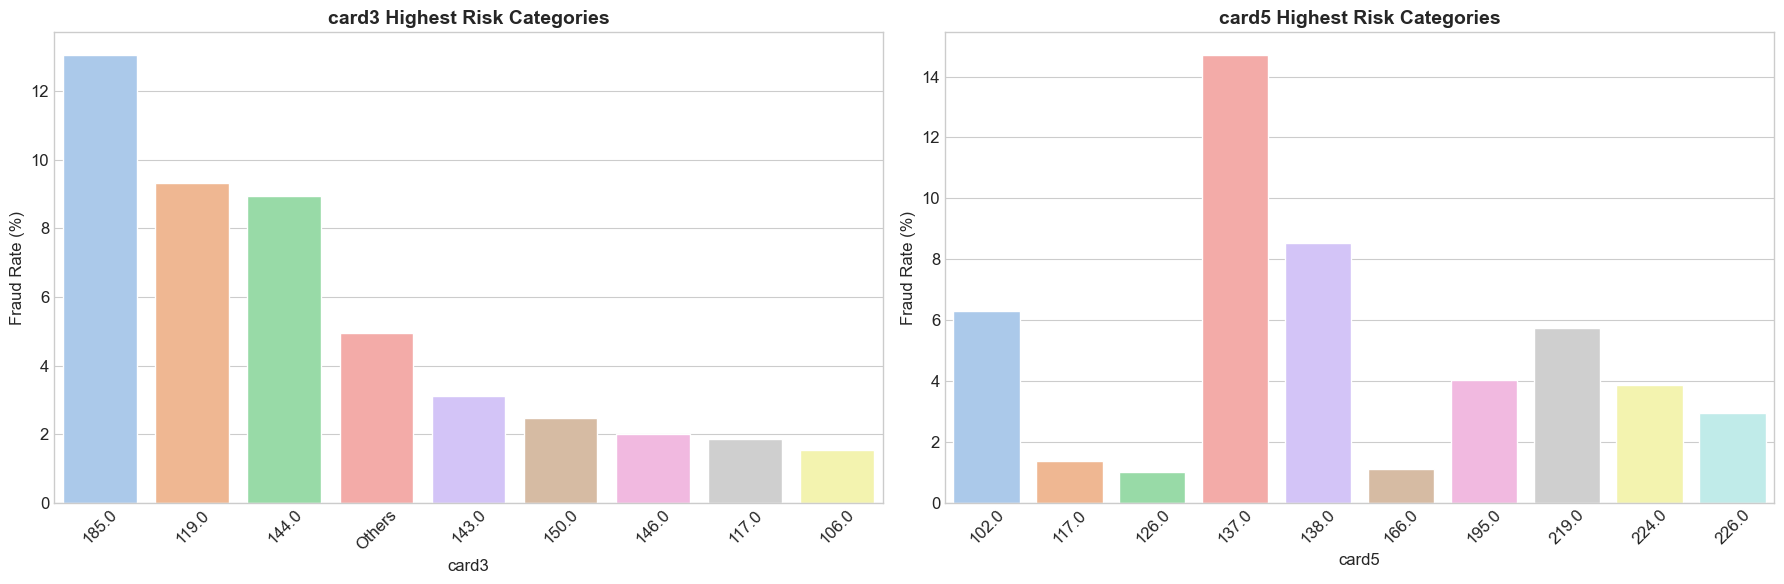

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for i, col in enumerate(['card3', 'card5']):
    top_categories = train_df[col].astype(str).value_counts().head(10).index
    
    plot_data = train_df[train_df[col].astype(str).isin(top_categories)]
    

    rate_df = plot_data.groupby(col)['isFraud'].mean().reset_index()
    rate_df.columns = [col, 'FraudRate']
    rate_df['FraudRate'] = rate_df['FraudRate'] * 100 
    rate_df = rate_df.sort_values(by='FraudRate', ascending=False)
    
    sns.barplot(
        x=col, 
        y='FraudRate', 
        data=rate_df, 
        palette='pastel', 
        ax=axes[i],
        edgecolor='white'
    )
    
    axes[i].set_title(f'{col} Highest Risk Categories', fontsize=14)
    axes[i].set_ylabel('Fraud Rate (%)')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In card5 the most frequent values are 226, 224, 166 that represents 73% of data. Also is posible to see high % of frauds in 137, 147, 141 that has few entries for values.

yukaıdaki görselde bu kategorilerin tüme oranı yok sadece risk durumları var.


##### ProductCD özelliği

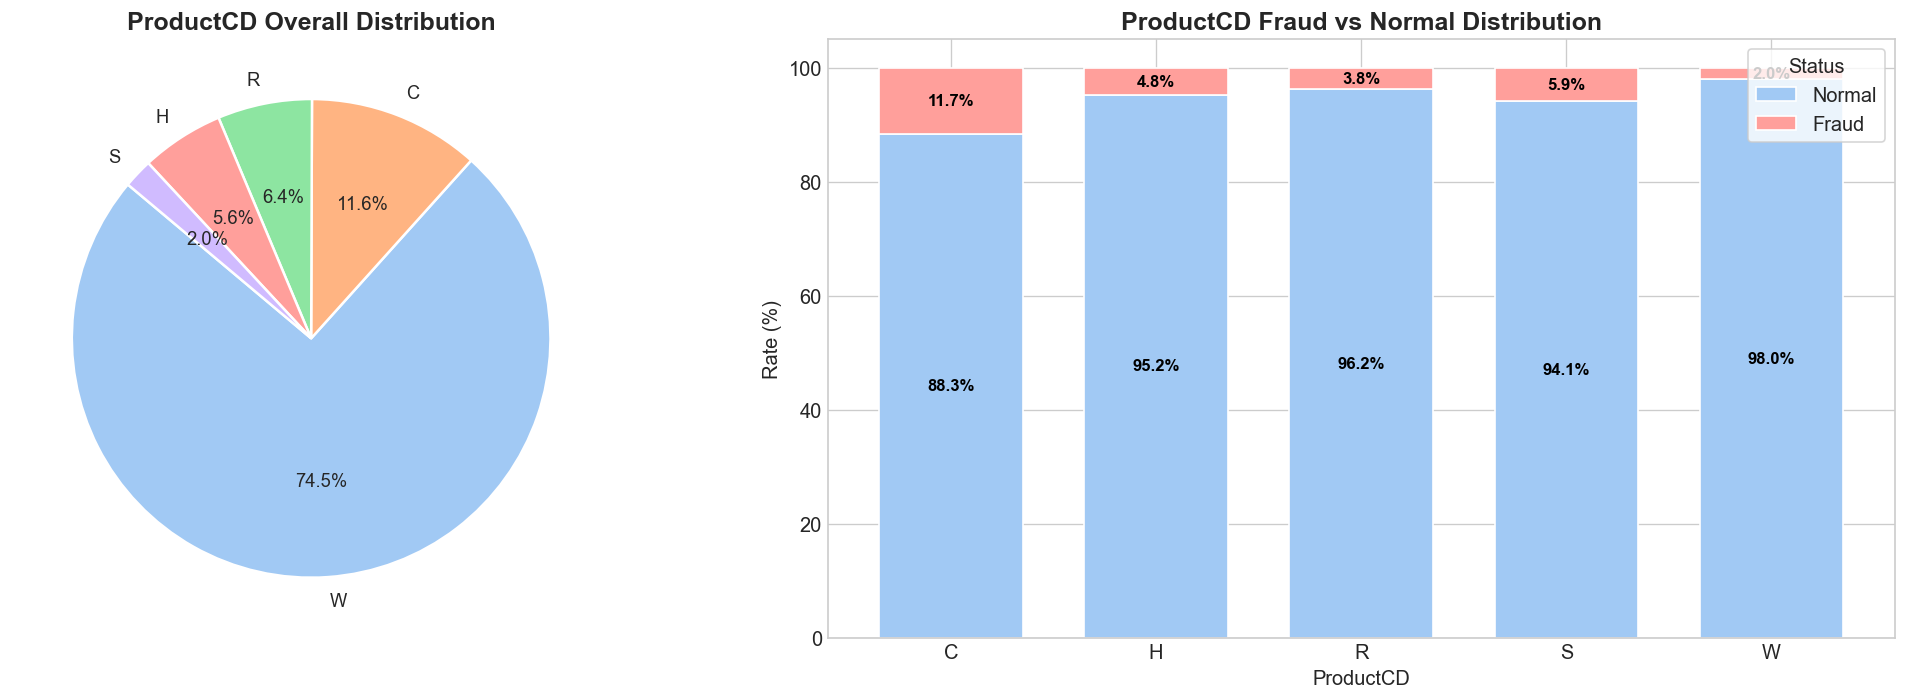

In [15]:
plot_categorical_analysis(train_df,'ProductCD')

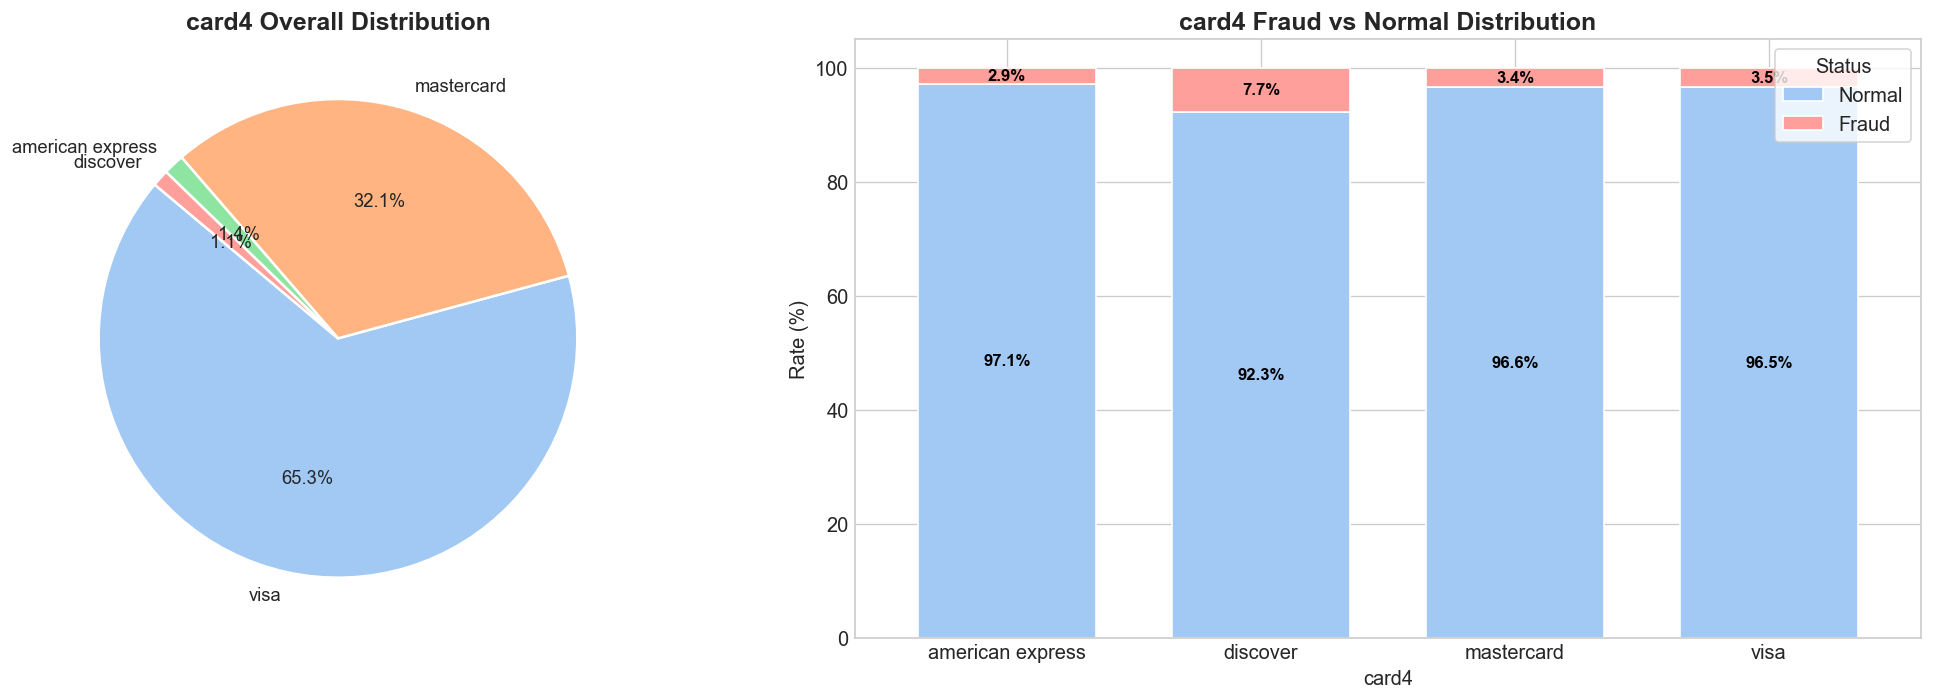

In [16]:
plot_categorical_analysis(train_df,'card4')

# New Features

Original Unique P_email Count: 59
Number of Grouped Unique P_email: 9
--- P_emaildomain (Purchaser)---


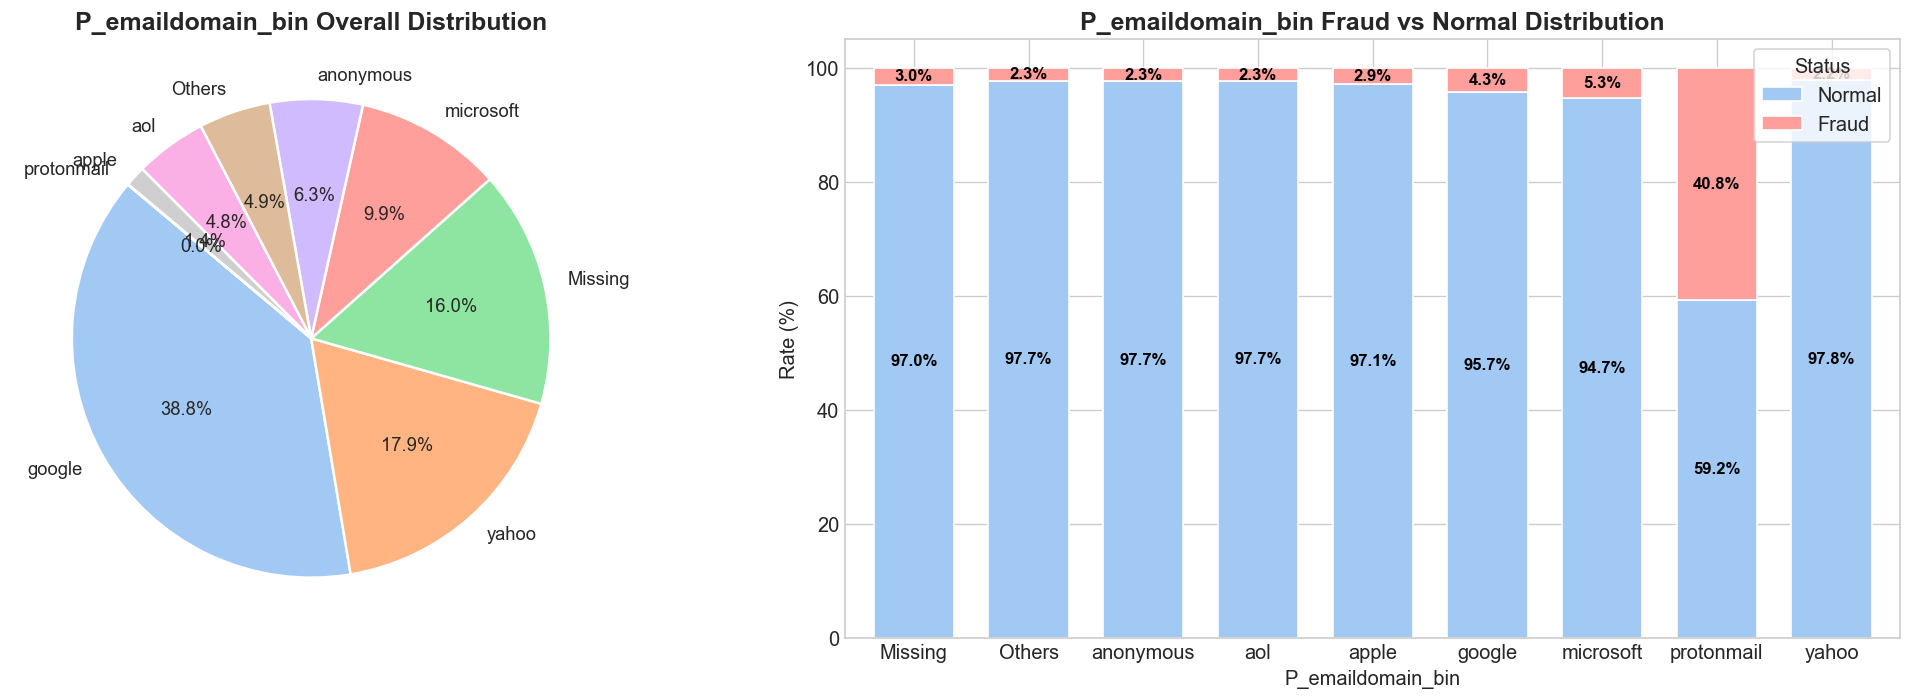


--- R_emaildomain (r-Recipient)---


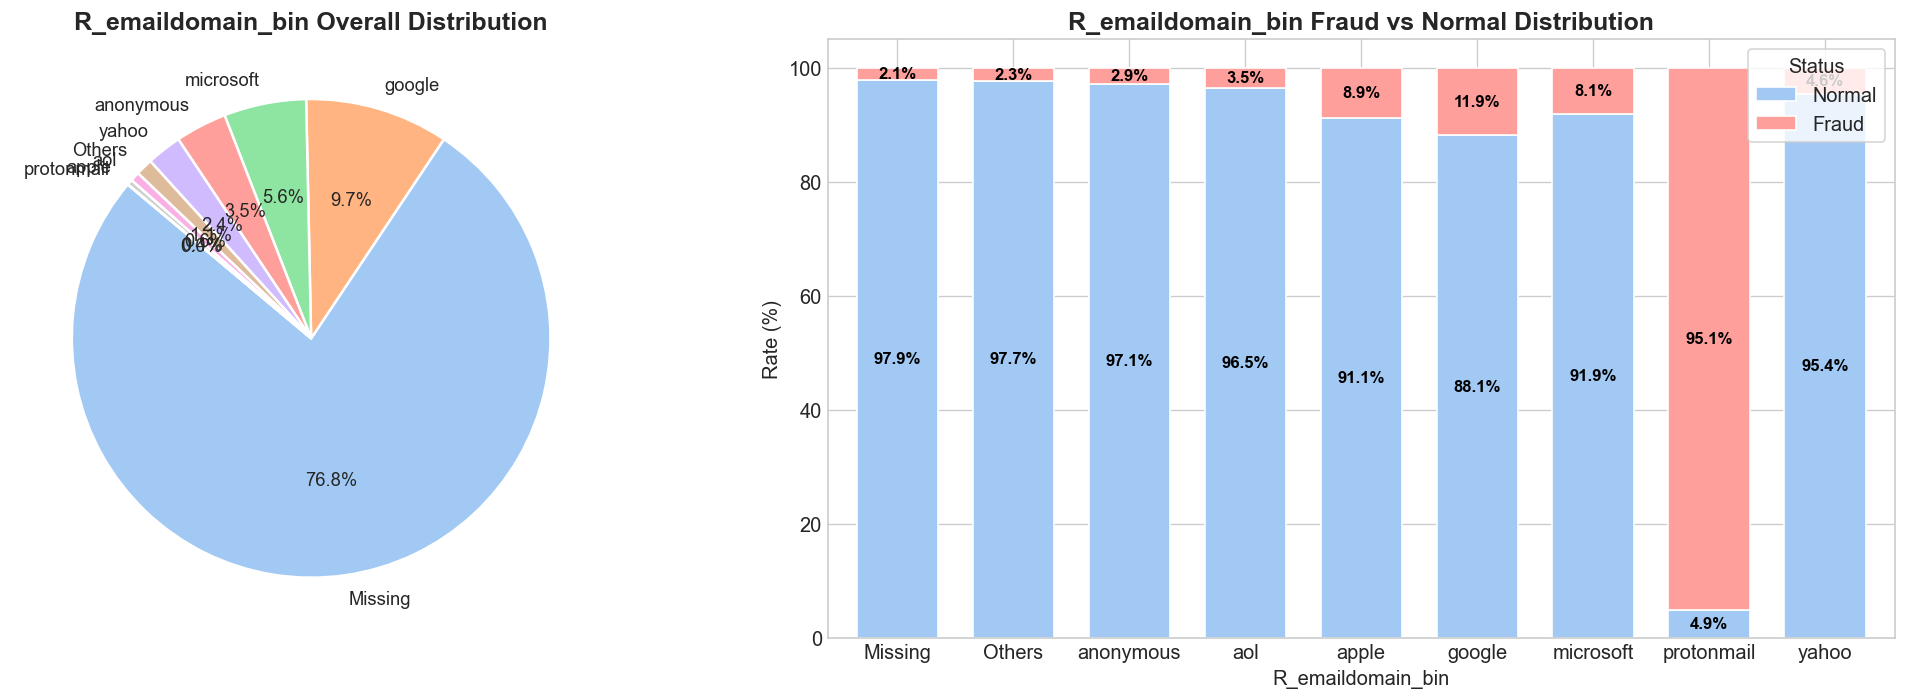

--- Satın Alan ve Alıcı E-posta Eşleşme ---


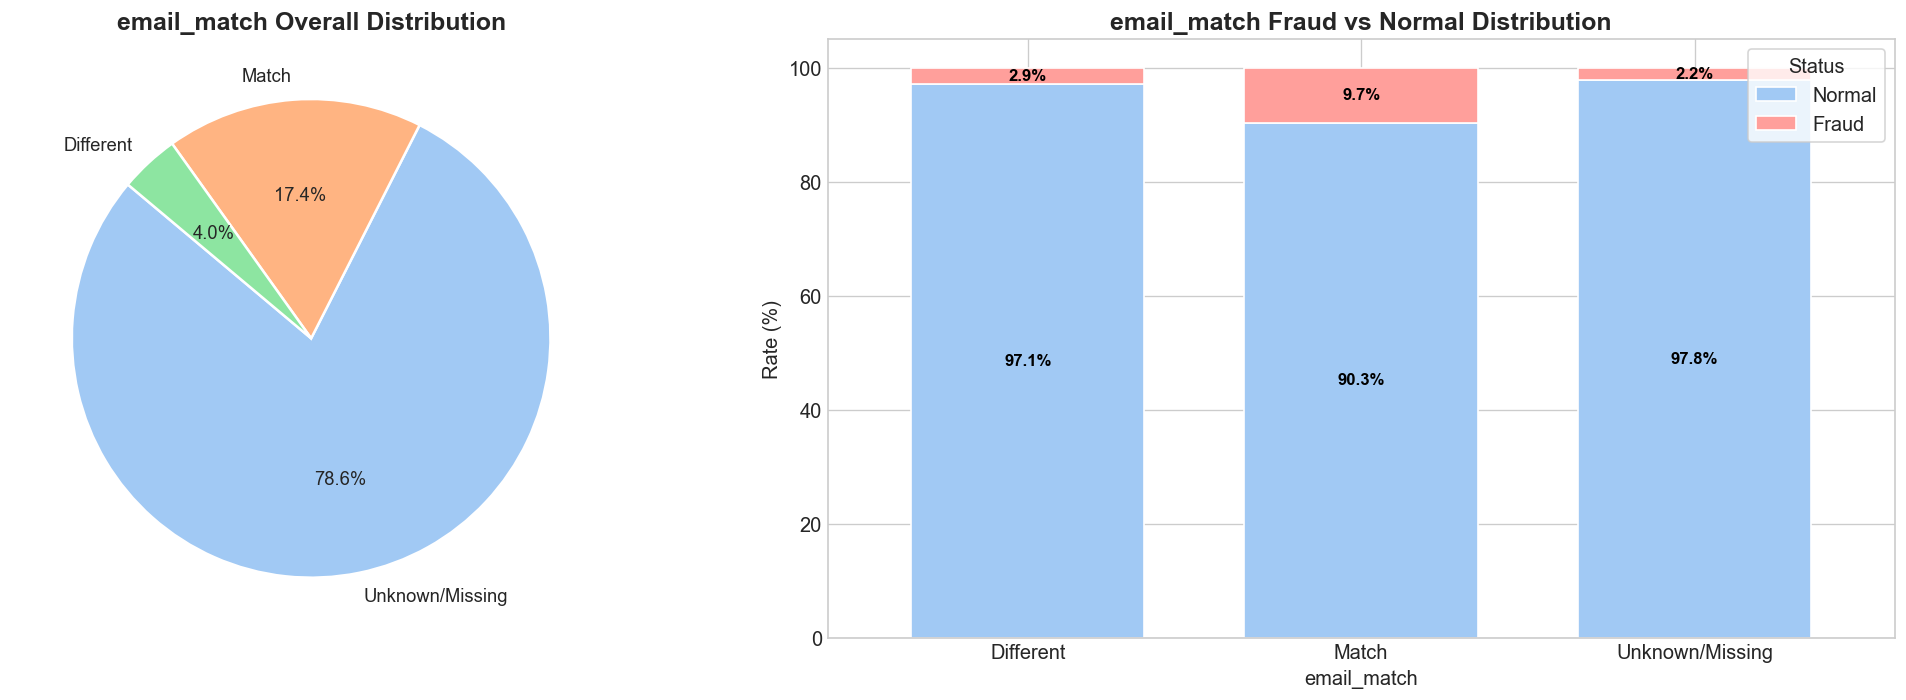

--- İşletim Sistemi (OS) ---


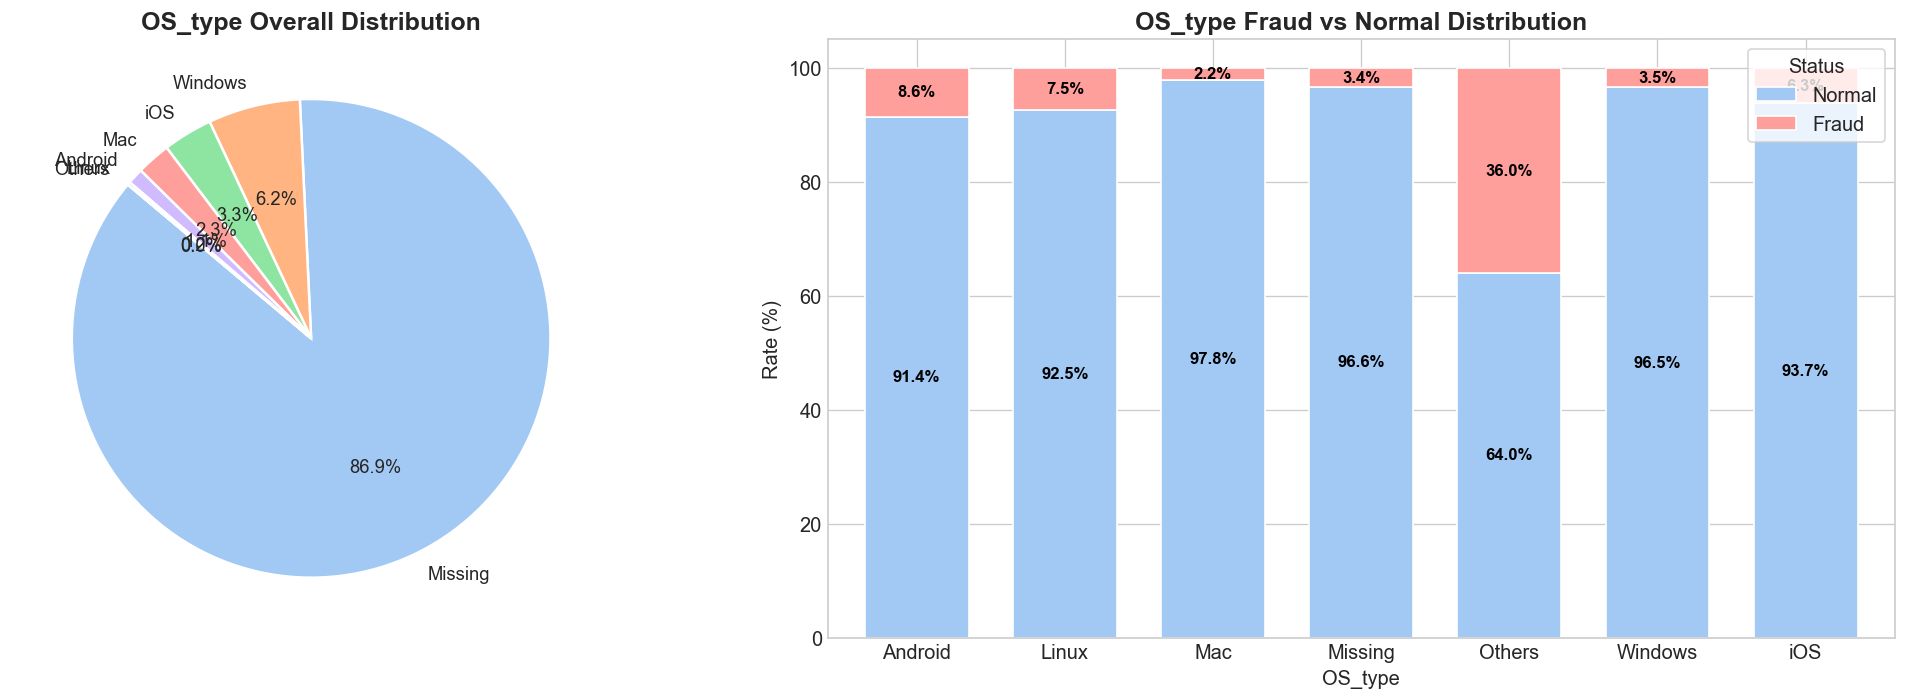


--- Cihaz Markası (Device) ---


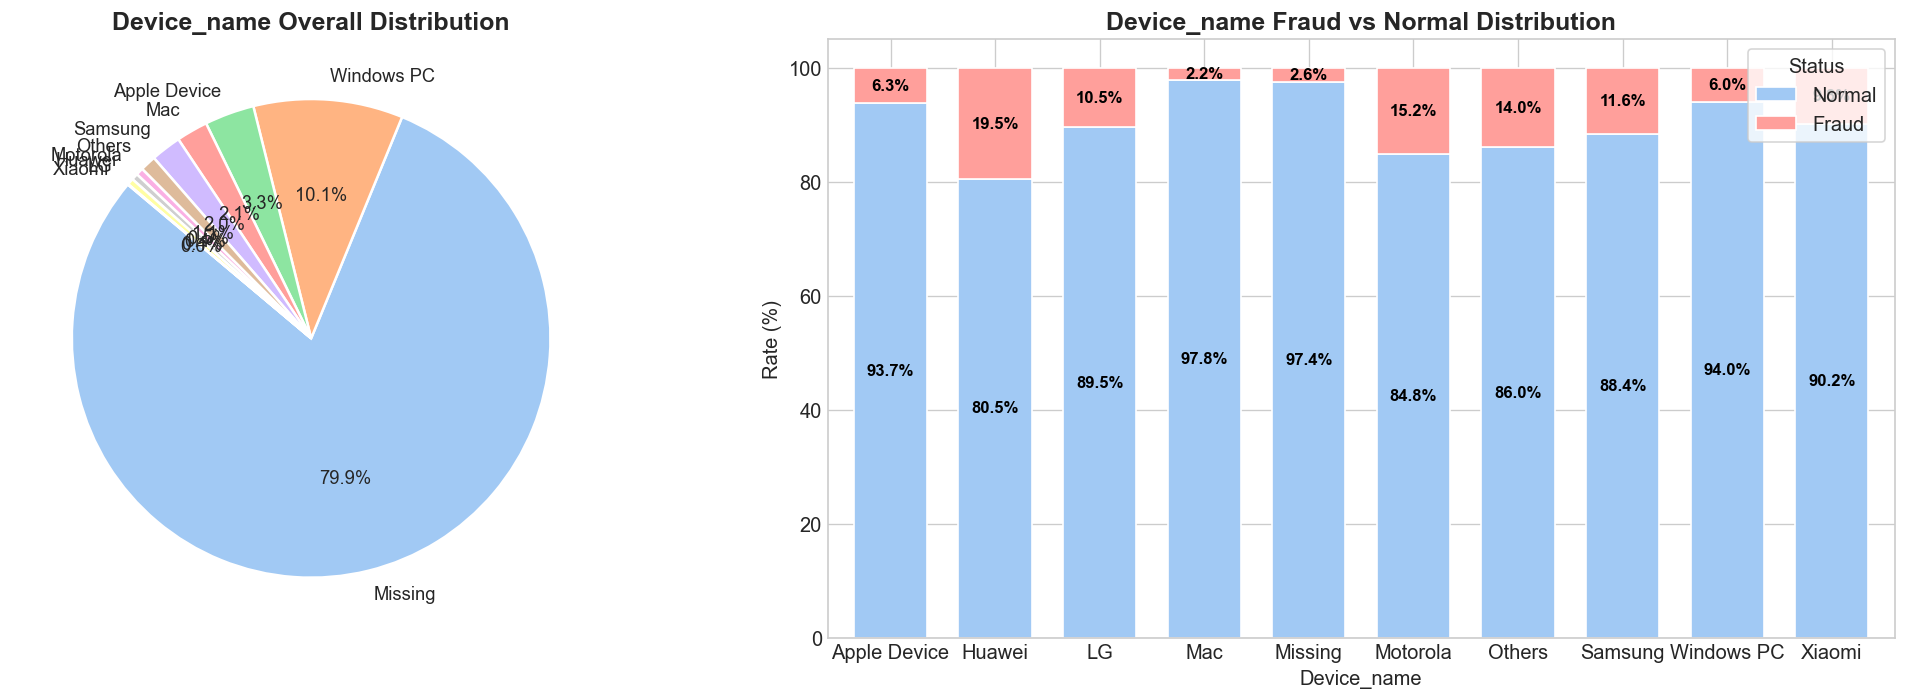


--- Ekran Çözünürlüğü inceleme ---


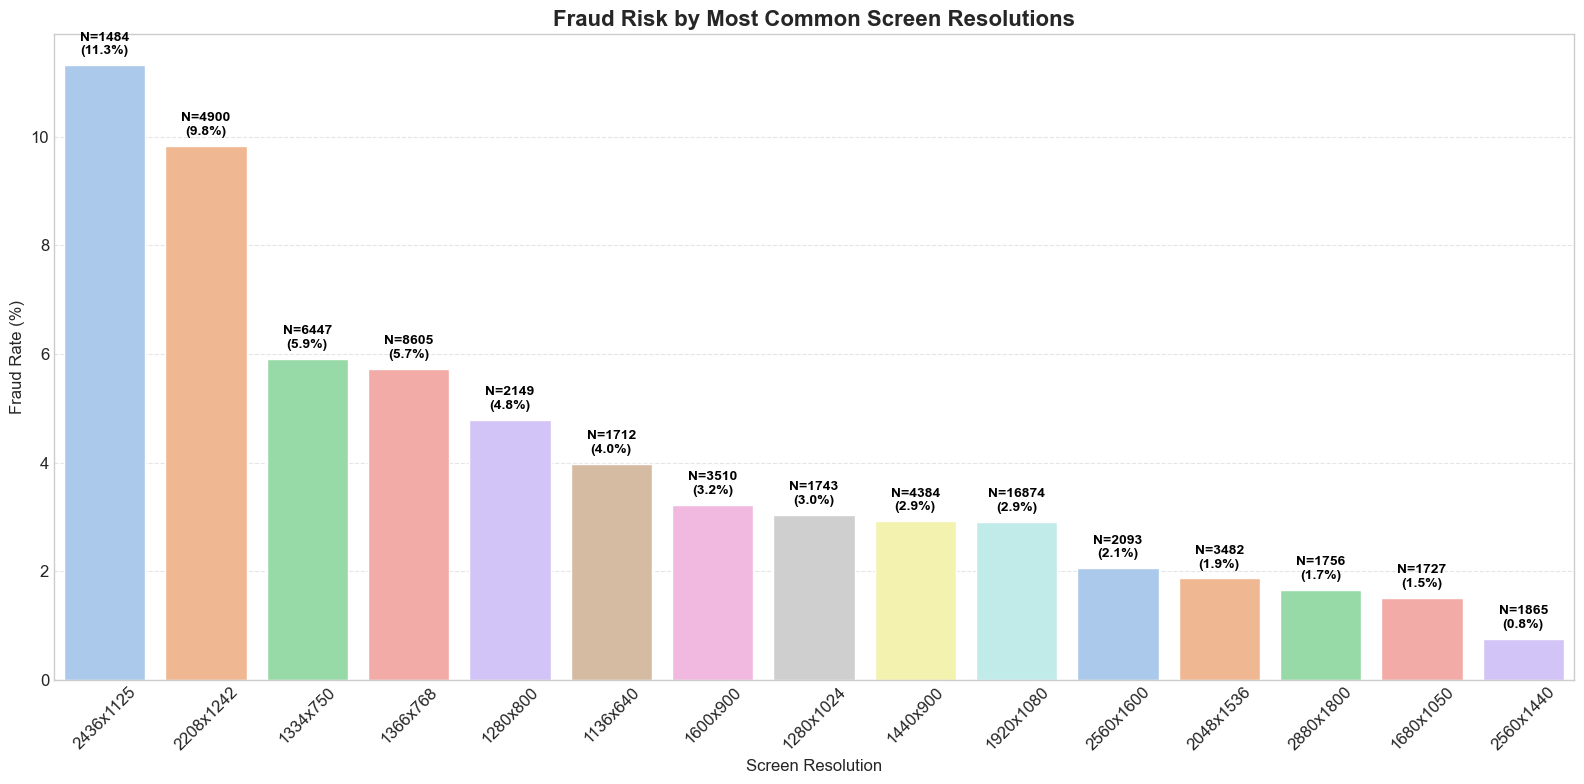


--- M1-M9---


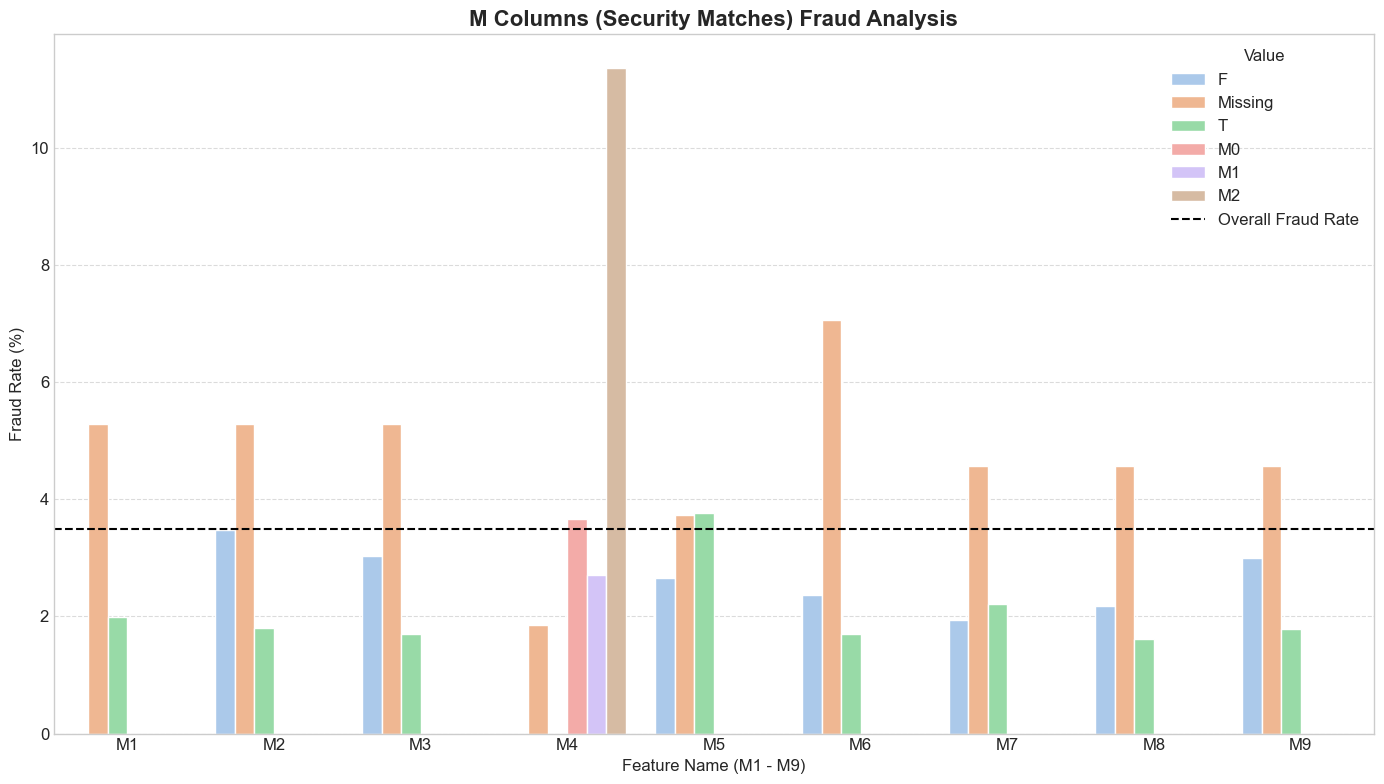

In [17]:
print("Original Unique P_email Count:", train_df['P_emaildomain'].nunique())
print("Number of Grouped Unique P_email:", train_df['P_emaildomain_bin'].nunique())

print("--- P_emaildomain (Purchaser)---") # alıcı
plot_categorical_analysis(train_df, 'P_emaildomain_bin')

print("\n--- R_emaildomain (r-Recipient)---") # faturayla ilgili
plot_categorical_analysis(train_df, 'R_emaildomain_bin')

print("--- Satın Alan ve Alıcı E-posta Eşleşme ---")
plot_categorical_analysis(train_df, 'email_match')

print("--- İşletim Sistemi (OS) ---")
plot_categorical_analysis(train_df, 'OS_type')

print("\n--- Cihaz Markası (Device) ---")
plot_categorical_analysis(train_df, 'Device_name')


print("\n--- Ekran Çözünürlüğü inceleme ---")
analyze_screen_resolution(train_df)

# print("\n--- Zamana Bağlı İnceleme ---")
# analyze_time_categories(train_df) yukarı zaten var.

print("\n--- M1-M9---")
analyze_m_columns(train_df)

- P_emaildomain veya R_emaildomain özellikleri proton_mail olması gözlemin çok yüksek ihtimalle dolandırıcı olduğunu gösteriyor.
- E-mail eşleşmesi olmaması durumunda dolandırıcılık ihtimalinin artmasını bekliyordum ancak tam tersi durum söz konusu.
- OS_Type özelliği incelendiğinde Others sınıfı bilinmeyenleri temsil ediyordu ve en çok dolandırıcılık vakası bu sınıftan çıkmış durumda. Ardından Android geliyor.
- Device_name özelliğinden yola çıkarak Bazı markaların kullanıcılarının daha fazla dolandırıcılık vakasına karıştığı görülebiliyor.
- Ekran çözünürlüğüne göre Fraud riski sıralandığında özellikle ilk iki sıra ile kalanlar arasında anlamlı bir fark söz konusu.
- card4 özelliğinin discover olması daha riskli diyebiliriz.
- ProductCD özelliğinin C değeri en riskli sınıf diyebiliriz.
- card3 ve card5 özellikleri için bazı değerler fraud ihtimalini arttırabiliyor.

# Bivariate Analysis

Kategorik Özelliklerden bazıları ufak düzenlemelerle tek başına dahi gözlemin Fraud olabileceğine dair anlamlı bilgiler veriyor aslında ancak bazı ikili kombinasyonlar sonucunda daha fazla bilgi almayı umuyorum.

Instead of manually testing each pair, scan ALL combinations and find the top riskiest ones.

In [18]:
categorical_to_scan = [
    'ProductCD', 'card4', 'card6', 
    'DeviceType', 'P_emaildomain_bin', 'R_emaildomain_bin',
    'email_match', 'OS_type', 'Device_name',
    'id_12', 'id_13', 'id_15', 'id_17', 'id_19', 'id_20',
    'id_23', 'id_28', 'id_29', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38'
]


top_combos = scan_all_bivariate_combinations(
    train_df, 
    categorical_to_scan, 
    min_samples=50,
    top_n=50
)

train_df = create_interaction_features_auto(
    train_df, 
    top_combos, 
    top_n=15,
    min_fraud_rate=20.0
)

Scanning 300 feature pairs...
Progress: 10/300 pairs processed...
Progress: 20/300 pairs processed...
Progress: 30/300 pairs processed...
Progress: 40/300 pairs processed...
Progress: 50/300 pairs processed...
Progress: 70/300 pairs processed...
Progress: 80/300 pairs processed...
Progress: 90/300 pairs processed...
Progress: 100/300 pairs processed...
Progress: 110/300 pairs processed...
Progress: 130/300 pairs processed...
Progress: 140/300 pairs processed...
Progress: 150/300 pairs processed...
Progress: 160/300 pairs processed...
Progress: 170/300 pairs processed...
Progress: 180/300 pairs processed...
Progress: 190/300 pairs processed...
Progress: 210/300 pairs processed...
Progress: 220/300 pairs processed...
Progress: 230/300 pairs processed...
Progress: 240/300 pairs processed...
Progress: 250/300 pairs processed...
Progress: 270/300 pairs processed...
Progress: 280/300 pairs processed...
Progress: 290/300 pairs processed...
Progress: 300/300 pairs processed...

Analysis comple

In [19]:
display(top_combos.head(5))

,feature1,feature2,subcat1,subcat2,fraud_rate,sample_count,fraud_count,combination
0,R_emaildomain_bin,id_33,google,1024x600,89.473684,57,51,R_emaildomain_bin x id_33: google + 1024x600
1,P_emaildomain_bin,id_33,Missing,1024x600,85.483871,62,53,P_emaildomain_bin x id_33: Missing + 1024x600
2,ProductCD,id_33,S,1024x600,85.483871,62,53,ProductCD x id_33: S + 1024x600
3,id_28,id_33,Found,1024x600,84.745763,59,50,id_28 x id_33: Found + 1024x600
4,id_15,id_33,Found,1024x600,84.615385,52,44,id_15 x id_33: Found + 1024x600


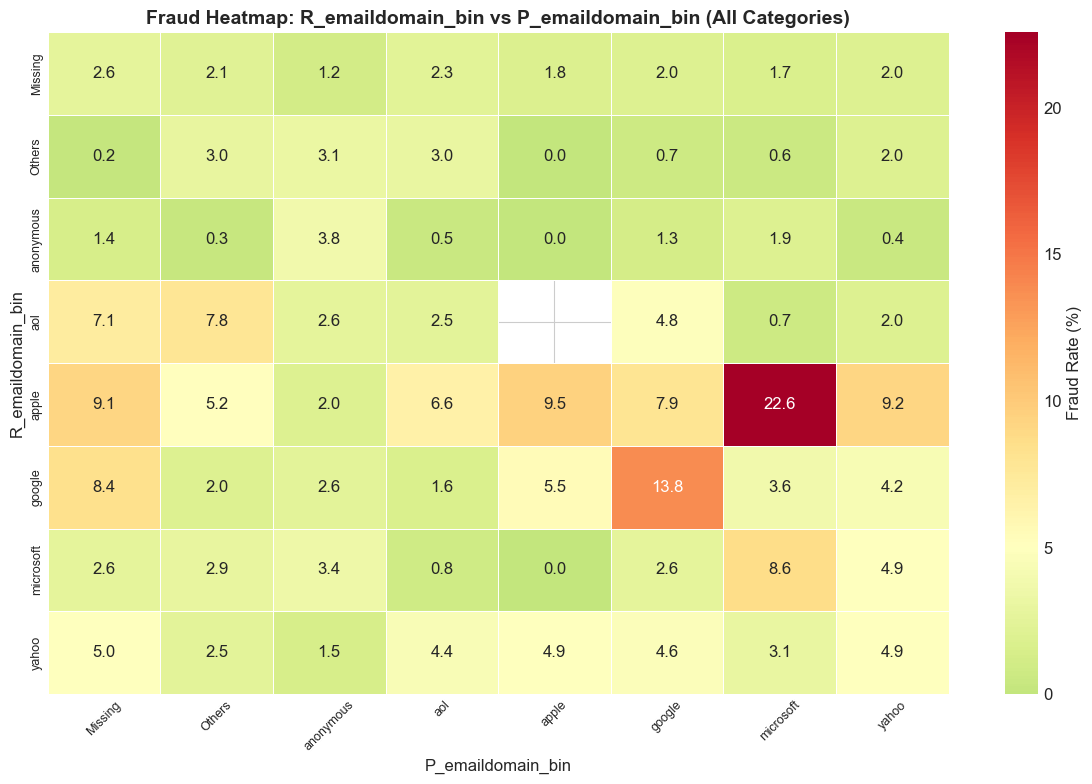

,R_emaildomain_bin,P_emaildomain_bin,fraud_count,total_count,fraud_rate
41,apple,microsoft,14,62,22.580645
48,google,google,6141,44526,13.791942
39,apple,apple,97,1026,9.454191
42,apple,yahoo,12,131,9.160305
35,apple,Missing,26,286,9.090909


In [20]:
bivariate_comb_risk(train_df, 'R_emaildomain_bin', 'P_emaildomain_bin' , min_samples= 50).head(5)

In [21]:
print("\n Oluşturulan Yeni Özellikler:")
display(train_df.created_interaction_features)
# display(train_df[train_df.created_interaction_features].head())


 Oluşturulan Yeni Özellikler:


['R_emaildomain_bin_x_id_33',
 'P_emaildomain_bin_x_id_33',
 'ProductCD_x_id_33',
 'id_28_x_id_33',
 'id_15_x_id_33',
 'id_29_x_id_33',
 'id_12_x_id_13',
 'email_match_x_id_33',
 'id_13_x_id_37',
 'id_13_x_id_29',
 'id_13_x_id_28',
 'id_13_x_id_15',
 'id_13_x_id_36',
 'R_emaildomain_bin_x_id_20',
 'P_emaildomain_bin_x_id_20']